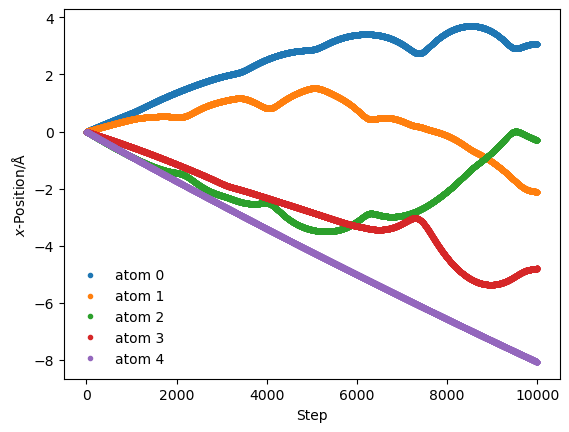

In [15]:
#Petra Budavari
#4/19/2024
#used pythoninclemistry.org
#run VMD with /packages/vmd/bin/vmd

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann
mass_of_argon = 39.948 # amu

def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma, 12) / np.power(
        r, 13) - 24 * epsilon * np.power(
        sigma, 6) / np.power(r, 7)


def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of 
    particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at 
        initialisation (K)
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of 
        particles (eVs/Åamu)
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / (
        mass_of_argon * 1.602e-19))

def get_accelerations(xpositions, ypositions):
    """
    Calculate the acceleration on each particle
    as a  result of each other particle. 
    N.B. We use the Python convention of 
    numbering from 0.
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, 
        for all of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each
        particle (eV/Åamu)
    """
    accel_x = np.zeros((xpositions.size, xpositions.size))
    accel_y = np.zeros((ypositions.size, ypositions.size))
    # accel_y = np.zeros((ypositions.size, ypositions.size))
    for i in range(0, xpositions.size - 1):
        for j in range(i + 1, xpositions.size):
            r_x = xpositions[j] - xpositions[i]
            r_y = ypositions[j] - ypositions[i]

            rmag = np.sqrt(r_x**2 + r_y**2)
            force_scalar = lj_force(rmag, 0.0103, 3.4)

            force_x = force_scalar * r_x / rmag
            force_y = force_scalar * r_y / rmag

            accel_x[i, j] = force_x / mass_of_argon
            accel_x[j, i] = - force_x / mass_of_argon

            accel_y[i, j] = force_y / mass_of_argon
            accel_y[j, i] = - force_y / mass_of_argon

        
    return np.sum(accel_x, axis=0), np.sum(accel_y, axis=0)

def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a 
        single dimension
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single 
        dimension
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension at the previous 
        timestep (eV/Åamu)
    a1: ndarray of floats
        The accelerations of the particles in a
        single dimension at the current 
        timestep (eV/Åamu)
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a
        single dimension (eVs/Åamu)
    """
    return v + 0.5 * (a + a1) * dt

def run_md(dt, number_of_steps, snaptime,initial_temp, x, y, number_of_atoms):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
    file = open('traj.xyz', 'w')

    xpositions = np.zeros((number_of_steps, number_of_atoms))
    ypositions = np.zeros((number_of_steps, number_of_atoms))

    xv = init_velocity(initial_temp, number_of_atoms)
    yv = init_velocity(initial_temp, number_of_atoms)
    # yv=0

    xa = get_accelerations(x,y)[0]
    ya = get_accelerations(x,y)[1]

    for i in range(number_of_steps):
        x = update_pos(x, xv, xa, dt)
        y = update_pos(y, yv, ya, dt)

        xa1 = get_accelerations(x,y)[0]
        ya1 = get_accelerations(x,y)[1]

        xv = update_velo(xv, xa, xa1, dt)
        yv = update_velo(yv, ya, ya1, dt)

        xa = np.array(xa1)
        ya = np.array(ya1)

        xpositions[i, :] = x
        ypositions[i, :] = y
        if i%snaptime == 0:
            file.write(str(number_of_atoms)+"\n")
            file.write("#\n")
            for atom in range(number_of_atoms):
               # print(atom)
                file.write("A\t" + str(x[atom])+ "\t" + str(y[atom]) +"\t0.0\n")


    return xpositions , ypositions



number_of_atoms=5
x=1+5*np.arange(number_of_atoms)
y=np.zeros(number_of_atoms)
# y=1+5*np.arange(number_of_atoms)
sim_posx = run_md(0.1, 10000,100, 300, x, y, number_of_atoms)[0]
sim_posy = run_md(0.1, 10000,100, 300, x, y, number_of_atoms)[1]


    
%matplotlib inline
for i in range(sim_posy.shape[1]):
    plt.plot(sim_posy[:, i], '.', label='atom {}'.format(i))
plt.xlabel(r'Step')
plt.ylabel(r'$x$-Position/Å')
plt.legend(frameon=False)
plt.show()
